# Correlation between bus delay and queue length
This code uses data averages over 2 weeks. Plots for one day are produced combining flow data of cars, queue length of cars and public transport (PT) data. I ran the code on google colab and created the following folder structure: \\

Colab Notebooks/PDM/NDOV/kv6_stop_departures : the PT data (per day) is found here \\
Colab Notebooks/PDM/Saved plots: for saving figures \\

Data:
- PT data from NDOV (in Colab Notebooks/PDM/NDOV/kv6_stop_departures)
- data from Arane data portal are imported with an API

## Analysis over 2 weeks

The data analysis over one hand couldn't yield sufficiently significant correlation. In order to reduce the irregularity of one specific day we now consider 2 weeks (maybe also 2 months) of data. 

For PT data the steps are the following: 
- loop over time period
    - import one day
    - calculate marginal delay and aggregate in dict per vri, bus line, and direction
    - aggregation by dt min (5 min)
    - add all data frames together pd.concat([df_all, df_new])
    
 For the queue length data: 
 - import in loop of 2 hours
 - time aggregation per vri and direction (N,O,Z,W)
 


In [1]:
#packages
import pandas as pd
import numpy as np
import math
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn
from datetime import datetime, timedelta
from dateutil import parser

#google drive connection
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Variables specific to the analysis

In [2]:
#Time
#-----------------------
####ENTER HERE YOUR DESIRED TIME PERIOD####
start = '01-04-2022'
end = '17-04-2022'
###########################################

#unixtimestamp milliseconds
start_ts = int(1000*datetime.strptime(start, '%d-%m-%Y').timestamp())
end_ts = int(1000*datetime.strptime(end, '%d-%m-%Y').timestamp())

#timestep for aggregation
dt = 5
#car specific variables
#-----------------------
vris = [89, 90, 111] #90
vris_txt = ['089', '090', '111'] # '090',
directions = ['N', 'O', 'Z', 'W']
#signalgroup IDs belonging to bikes and outflows can be found in the excel provided by Utrecht
signalgroups_bikes = {89: [22, 24, 26, 28, 82, 83, 86], 
                     90: [22, 23, 24, 26, 27, 82, 86],
                     111: [82, 86, 88]}
signalgroups_outflows ={89:[1011, 2011, 1002, 1005, 2005, 2008, 3008],
                        90: [1022, 1024, 1026, 1028, 1082, 1086],
                        111: [1086, 7, 9, 24, 26, 45, 62, 64, 65, 66, 68, 70, 71, 75]}
#movements which I will omit to improve readability are also grouped in signalgroups_outflows like 7 and 9 
#PT specific variables
#----------------------
buslines = ['u001', 'u010', 'u034', 'u047']
#convention for bus stops: 
    #first key: vri
    #second key: busline
    #4 busstops order before and after the intersection, in both travel directions
busstops = {89: {'u001':['50002380', '50001270', '50001282', '50002370'], 
                        'u010':['50001300', '50001270', '50001282','50001290'],
                        'u034':['50001300', '50001270', '50001282','50001290'],
                        'u047':['50001300','50001400', '50001390', '50001290']},
                    90: {'u001':[], 
                        'u010':['50006470', '50001300', '50001290', '50006480'],
                        'u034':[],
                        'u047':[]},
                   111: {'u001':['50002360', '50001270', '50001282', '50002350'], 
                        'u010':['50001300', '50001232', '50001241','50001290'], 
                        'u034':['50001300', '50001232', '50001241','50001290'],
                        'u047':[]}}
#for intersection 111: bus lines 10 and 34 are considered over the whole Socrateslaan intersection 
#(the bus stop on the intersection is not considered, because in the middle of the intersection)

### PT data

In [3]:
def calculate_marg_delay(df, vris, buslines, busstops):
  delay = {v:{l: {d:{'marg_delay':[], 'time': [], 'journeynumber':[]} for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
      for line in buslines: 
          #if busstops[vri][line] is not empty
          if busstops[vri][line]:
              df_line = []
              df_line = df[df.lineplanningnumber == line].reset_index(drop = True) 
              #drop weekends and national holidays
              df_line['weekend'] = [datetime.strptime(x, '%Y-%m-%d').weekday()>4 for x in df_line.operatingday]
              df_line = df_line.drop(df_line[df_line['weekend'] == True].index)
              df_line = df_line.drop(df_line[df_line.operatingday.apply(lambda x: x in ['2022-04-15', '2022-04-18', '2022-04-27'])].index) #dutch holidays
              #divison per trip saves time of the associated delay (no aggregation over time)
              trips = df_line.journeynumber.unique()
              for trip in trips:
                  df_trip = df_line[df_line.journeynumber == trip].reset_index(drop = True)
                  bstp = {}
                  #for readability use bstp[i]
                  for i in range(4):
                      bstp[i] = busstops[vri][line][i]
                  for d in range(2):    
                      df_stp0 =df_trip[df_trip.userstopcode == bstp[2*d]]
                      df_stp1 =df_trip[df_trip.userstopcode == bstp[2*d+1]]
                      #consider the moment of departure for the delay at a busstop
                      delay_stp0 = df_stp0[df_stp0.messagetype == 'DEPARTURE'].punctuality.values
                      delay_stp1 = df_stp1[df_stp1.messagetype == 'DEPARTURE'].punctuality.values
                      if delay_stp0.size*delay_stp1.size: #if one of the 2 delays is nan then don't compute difference
                          try : 
                            new_delay = np.mean(delay_stp1 - delay_stp0) #mean because sometimes 2 values for delay at departure
                            delay[vri][line][d]['marg_delay'].append(new_delay) 
                            t = parser.parse(df_stp0[df_stp0.messagetype == 'DEPARTURE'].receive.iloc[0])
                            delay[vri][line][d]['time'].append(t)
                            delay[vri][line][d]['journeynumber'].append(trip)
                          except :
                            pass
  return delay

In [4]:
def time_aggregation_PT(delay, dt, vris, buslines):
  delay_agg = {v:{l: {d:{'marg_delay':[], 'time': [], 'journeynumber':[]} for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
      for line in buslines:
          for d in range(2):
              delay_agg[vri][line][d] = pd.DataFrame(delay[vri][line][d])
              if not delay_agg[vri][line][d].empty:
                  delay_agg[vri][line][d].set_index(delay_agg[vri][line][d]['time'], inplace = True)
                  delay_agg[vri][line][d] = delay_agg[vri][line][d][delay_agg[vri][line][d].marg_delay.notnull()].resample('{}T'.format(dt)).agg({'marg_delay':['mean', 'std'], 'journeynumber': 'first'})
                  #print(delay_agg[vri][line][d].head())
  return delay_agg



In [5]:
def determine_initial_delay(df, vris, buslines, busstops):
  delay = {v:{l: {d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
    for line in buslines: 
      #if busstops[vri][line] is not empty
      if busstops[vri][line]:
        df_line = []
        df_line = df[df.lineplanningnumber == line].reset_index(drop = True) 
        #drop weekends and national holidays
        df_line['weekend'] = [datetime.strptime(x, '%Y-%m-%d').weekday()>4 for x in df_line.operatingday]
        df_line = df_line.drop(df_line[df_line['weekend'] == True].index)
        df_line = df_line.drop(df_line[df_line.operatingday.apply(lambda x: x in ['2022-04-15', '2022-04-18', '2022-04-27'])].index) #dutch holidays
        #iteration over busstops
        for idx,stp in enumerate(busstops[vri][line][::2]):
          df_stp =df_line[df_line.userstopcode == stp]
          df_stp_t = df_stp[df_stp.messagetype == 'DEPARTURE'].reset_index(drop = True)
          if not df_stp_t.empty:
            df_stp_t['time'] = [parser.parse(x) for x in df_stp_t[df_stp_t.messagetype == 'DEPARTURE'].receive]
          delay[vri][line][idx] = df_stp_t
  return delay


#### Marginal delay over each intersection 
stored variable: bus_agg_compl[vri][line][d]

In [6]:
#initialisation
bus_agg_compl = {v:{l: {d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
#import
date_ts = datetime.fromtimestamp(start_ts/1000)
while not date_ts == datetime.fromtimestamp(end_ts/1000):
    date_string = date_ts.strftime("%Y%m%d")
    with open("/content/gdrive/MyDrive/Colab Notebooks/PDM/NDOV/kv6_stop_departures/kv6-{}.log.csv".format(date_string)) as file:
        kv6 = pd.read_csv(file, sep= ",", index_col=0)
    kv6.userstopcode = [str(x) for x in kv6.userstopcode]
    #calculate marg delay
    delay= calculate_marg_delay(kv6, vris, buslines, busstops)
    #aggregation per dt (5min)
    delay_agg = time_aggregation_PT(delay, dt, vris, buslines)
    #add data frames together
    for vri in vris: 
      for line in buslines:
        for d in range(2):
          if not delay_agg[vri][line][d].empty:
            bus_agg_compl[vri][line][d] = pd.concat([bus_agg_compl[vri][line][d], delay_agg[vri][line][d]])
    #update date_timestep
    date_ts += timedelta(days=1)
    if date_ts == datetime.fromtimestamp(end_ts/1000):
        break
    

#### Delay before intersection 
stored variable: delay_bf[vri][line]

In [8]:
#initialisation
delay_bf = {v:{l: {d:pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
#import
date_ts = datetime.fromtimestamp(start_ts/1000)
while not date_ts == datetime.fromtimestamp(end_ts/1000):
    date_string = date_ts.strftime("%Y%m%d")
    with open("/content/gdrive/MyDrive/Colab Notebooks/PDM/NDOV/kv6_stop_departures/kv6-{}.log.csv".format(date_string)) as file:
        kv6 = pd.read_csv(file, sep= ",", index_col=0)
    kv6.userstopcode = [str(x) for x in kv6.userstopcode]
    #df per vri, line
    delay = determine_initial_delay(kv6, vris, buslines, busstops)

    #aggregation per dt (5min) & #add data frames together
    for vri in vris: 
      for line in buslines:
        for d in range(2):
          df = delay[vri][line][d]
          if not df.empty:
            #set time as index
            df.set_index('time', inplace = True)
            #time aggregation on time interval dt
            df = df.resample('{}T'.format(dt)).agg({'punctuality':['mean', 'std'], 'journeynumber': 'first', 'userstopcode': 'first', 'weekend': 'first'})
            delay_bf[vri][line][d] = pd.concat([delay_bf[vri][line][d], df])
    #update date_timestep
    date_ts += timedelta(days=1)
    if date_ts == datetime.fromtimestamp(end_ts/1000):
        break

### Queue length data
(it takes about 11 min to import the data. if proxy error, just run again)

In [10]:
#queuelength from AFM dataportal 
interval = end_ts-start_ts
twohours = 2*60*60*1000
if interval > twohours:
    start_prov = start_ts
    q_estimator= pd.DataFrame()
    #data_agg =pd.DataFrame(data_agg)
    for i in range(round(interval/twohours)):
        start_prov = start_ts + i*twohours
        end_prov = start_prov + twohours
        #print('{} start time: {} \n end time: {}'.format(i, timefromtimestamp(start_prov), timefromtimestamp(end_prov)))
        #load data
        with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/wachtrijschatter?startTime={}&endTime={}".format(start_prov, end_prov)) as f:
            data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp', 'timestamp_actueel' ], record_path=['opstelvakken'])
        df = pd.DataFrame(data_norm)
        #add new data to aggregated df
        q_estimator = pd.concat([q_estimator, df])

In [12]:
#time formatting
#function to get formated time from unix timestamp (AFM data)
def timefromtimestamp(timestamp):
    time_h = pd.to_datetime(datetime.fromtimestamp(timestamp/1000))
    return time_h
#Queue length=====
q_estimator['time'] = [timefromtimestamp(x) for x in q_estimator['timestamp']]

In [13]:
#resample data of queue estimator
queuelength = {v:{d:{} for d in directions}for v in vris}
for idx,vri in enumerate(vris):
    vri_txt = vris_txt[idx]
    #df of intersection
    df_vri = q_estimator[q_estimator.opstelvak_id.str.contains('UTR_{}_'.format(vri_txt))].reset_index(drop = True)
    #drop weekends and public holidays
    #drop weekends and national holidays
    df_vri['weekend'] = [x.weekday()>4 for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['weekend'] == True].index)
    df_vri['holiday'] = [datetime.strftime(x, '%Y-%m-%d') in ['2022-04-15', '2022-04-18', '2022-04-27'] for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['holiday'] == True].index) #dutch holidays

    for d in directions:
        #df of direction at intersection vri
        df_d = df_vri[df_vri.opstelvak_id.str.contains('UTR_{}_{}'.format(vri_txt, d))]
        #set time as index
        df_d.set_index('time', inplace =True)
        #time aggregation on time interval dt
        df_d= df_d.resample('{}T'.format(dt)).agg({'buffervulling_m':['mean', 'std'], 'opstelvak_id': 'first'})
        queuelength[vri][d] = df_d

### Status INM system 

In [14]:
#vrisupervisor from AFM dataportal 
interval = end_ts-start_ts
twohours = 2*60*60*1000
if interval > twohours:
    start_prov = start_ts
    vrisupervisor = pd.DataFrame()
    #data_agg =pd.DataFrame(data_agg)
    for i in range(round(interval/twohours)):
        start_prov = start_ts + i*twohours
        end_prov = start_prov + twohours
        #print('{} start time: {} \n end time: {}'.format(i, timefromtimestamp(start_prov), timefromtimestamp(end_prov)))
        #load data
        with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/vrisupervisor?startTime={}&endTime={}".format(start_prov, end_prov)) as f:
            data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp'], record_path=['vris'])
        df = pd.DataFrame(data_norm)
        #add new data to aggregated df
        vrisupervisor = pd.concat([vrisupervisor, df])

#time formatting VRI SUPERVISOR
vrisupervisor['time'] = [timefromtimestamp(x) for x in vrisupervisor['timestamp']]

In [15]:
def is_INM_on(df_vri):
  functions = ['is_master', 'is_cleaner', 'is_guard', 'is_slave']
  df_vri['status_on'] = False
  for func in functions:
    df_vri['status_on'] = df_vri['status_on'] + (df_vri[func] > 0.5)
  return df_vri

In [16]:
#resample data of vri supervisor
status_INM = {v:{}for v in vris}
for idx,vri in enumerate(vris):
    vri_txt = vris_txt[idx]
    #df of intersection
    df_vri = vrisupervisor[vrisupervisor.vri == 'K0{}'.format(vri_txt)].reset_index(drop = True)
    #drop weekends and public holidays
    df_vri['weekend'] = [x.weekday()>4 for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['weekend'] == True].index)
    #drop weekends and national holidays
    df_vri['holiday'] = [datetime.strftime(x, '%Y-%m-%d') in ['2022-04-15', '2022-04-18', '2022-04-27'] for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['holiday'] == True].index) #dutch holidays
    #display(df_vri)
    #set time as index
    df_vri.set_index('time', inplace =True)
    #time aggregation on time interval dt
    df_vri= df_vri.resample('{}T'.format(dt)).agg({'is_master':'mean', 'is_cleaner': 'mean', 'is_slave': 'mean', 'is_guard': 'mean'})
    # overall status (if any function is activated)
    df_vri = is_INM_on(df_vri)
    status_INM[vri] = df_vri



In [17]:
vri = 111
print('intersection 111 is only master')
#display(status_INM[vri][status_INM[vri].is_master >0])
vri = 89
print('intersection 89 is only cleaner')
#display(status_INM[vri][status_INM[vri].is_cleaner >0])
vri = 90
print('intersection 90 is never activated')
#display(status_INM[vri][status_INM[vri].is_master >0])

intersection 111 is only master
intersection 89 is only cleaner
intersection 90 is never activated


## Combined data frame 
df containing: 
- time
- bufferfilling (in m)
- marginal delay (over the intersection)
- initial delay (before the intersection)
- status on (true if any function (master, slave, …) is active more then 50 % of the time interval)


In [18]:
df_comb = {v:{l:{d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
for vri in vris:
  for line in buslines:
    for d in range(2):
      ##combined df
      combined = pd.DataFrame()
      combined = status_INM[vri]
      
      ##queue length
      if d == 0: 
        D = 'O'
      elif d == 1: 
        D = 'W'
      ql_m = queuelength[vri][D]['buffervulling_m']['mean']
      combined = combined.join(ql_m, rsuffix='_ql')

      ##PT marg delay & initial delay
      #if busstops not empty, delay has been computed otherwise no need to add to df
      if busstops[vri][line]:
        #marginal delay
        marg_delay_s = bus_agg_compl[vri][line][d]['marg_delay']['mean']
        combined = combined.join(marg_delay_s, rsuffix='_marg_delay')

        #initial delay
        init_delay_s = delay_bf[vri][line][d]['punctuality']['mean']
        combined = combined.join(init_delay_s, rsuffix='_init_delay')

      else:
        combined['mean_marg_delay']= np.nan
        combined['mean_init_delay'] = np.nan

      combined = combined.rename(columns={'mean': 'ql_m', 'mean_marg_delay': 'marg_delay', 'mean_init_delay': 'init_delay'})
      
      #print('vri: {}, line:{}, direction:{}'.format(vri, line, d))
      #display(combined[combined.init_delay > 60].head(5))
      df_comb[vri][line][d] = combined

#### Correlation plots seperate according to INM status
- correlation queue length - marginal delay
- correlation queue length - initial delay
- correlation initial - marginal delay

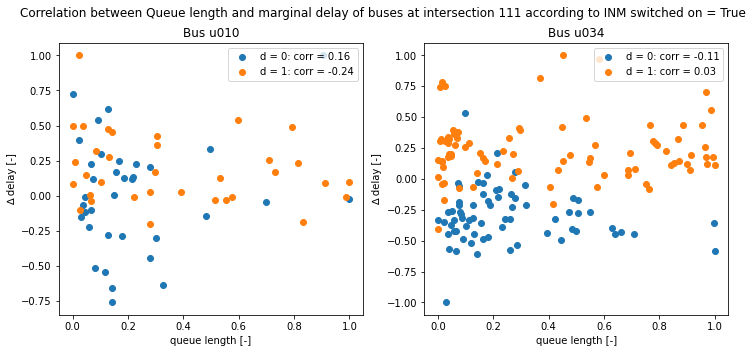

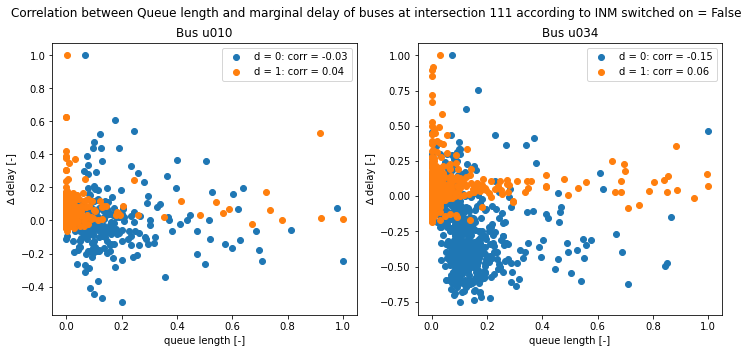

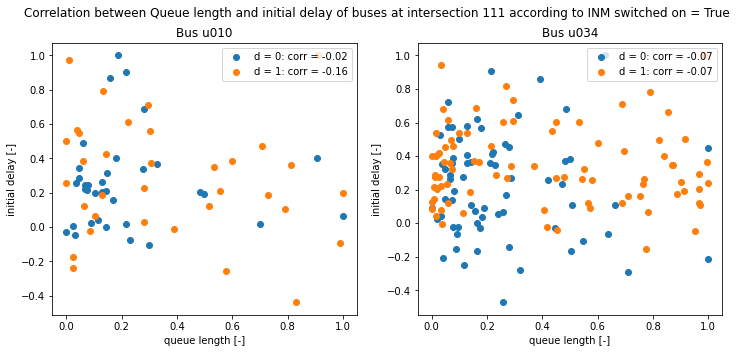

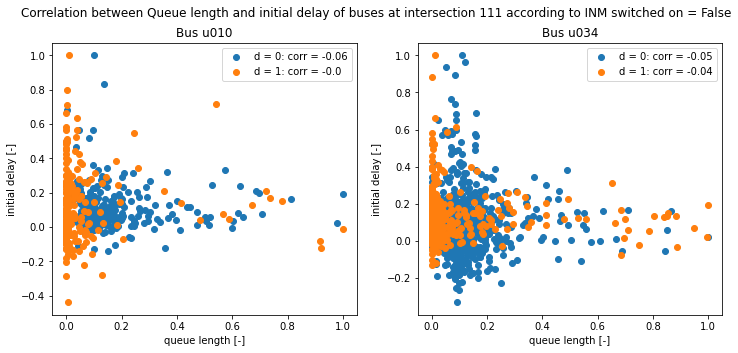

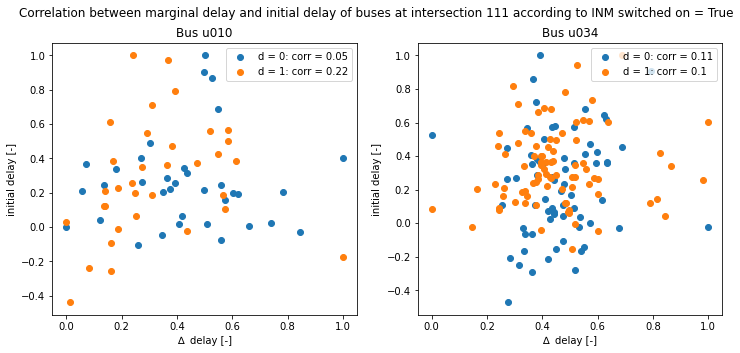

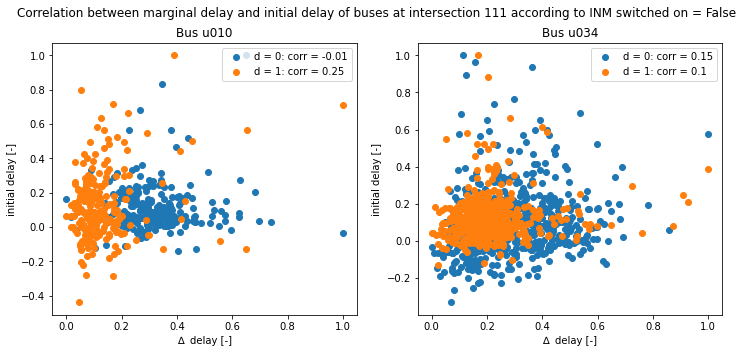

In [19]:
### correlation queue length - marginal delay
#==============================================

#Normalisation to 0,1 / or -1,1
normalised = 'yes'
#intersection of interest
vri= 111
#busline of interest
# vri 89:'u001', 'u010', 'u034', 'u047'
# vri 111: 'u010', 'u034'
lines = ['u010', 'u034']
for status in [True,False]:    
  fig = plt.figure(figsize=(len(lines)*6, 5))
  for i,line in enumerate(lines): 
      #plots
      ax=plt.subplot(1,len(lines), i+1)
      ax.grid(visible = None, which = 'both')
      ax.set_xlabel('queue length [-]')
      #ax.set_xlim([-0.1, 1.1])
      ax.set_ylabel('∆ delay [-]')
      #ax.set_ylim([-0.1, 1.1])
      ax.set_title('Bus {}'.format(line))
      plt.suptitle('Correlation between Queue length and marginal delay of buses at intersection {} according to INM switched on = {}'.format(vri, status))

      for d in [0,1]:
        df_conditional = df_comb[vri][line][d][df_comb[vri][line][d]['status_on']== status].reset_index(drop=True)
        #drop nan
        df_conditional=df_conditional.dropna()
        x= df_conditional['ql_m']
        y= df_conditional['marg_delay']

        #calculate rho
        rho = np.corrcoef(x, y)
        #normalised plot
        if normalised == 'yes':
            x_norm =(x-np.min(x))/(np.max(x)-np.min(x))
            y_norm = y/np.max(abs(y))
            ax.scatter(x_norm, y_norm, label = 'd = {}: corr = {}'.format(d, round(rho[0,1], 2)))
        else:
            ax.scatter(x, y, label = 'd {}: corr = {}'.format(d, round(rho[0,1], 2)))

      ax.legend(loc='upper right')
  plt.show()
  #save figure
  fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Separated status/correlation_status_{}_vri{}_date_{}_{}_marg_delay_norm_{}.pdf'.format(status, vri, start, end, normalised))


### correlation queue length - intial delay
#==============================================
for status in [True,False]:    
  fig = plt.figure(figsize=(len(lines)*6, 5))
  for i,line in enumerate(lines): 
      #plots
      ax=plt.subplot(1,len(lines), i+1)
      ax.grid(visible = None, which = 'both')
      ax.set_xlabel('queue length [-]')
      #ax.set_xlim([-0.1, 1.1])
      ax.set_ylabel('initial delay [-]')
      #ax.set_ylim([-0.1, 1.1])
      ax.set_title('Bus {}'.format(line))
      plt.suptitle('Correlation between Queue length and initial delay of buses at intersection {} according to INM switched on = {}'.format(vri, status))

      for d in [0,1]:
        df_conditional = df_comb[vri][line][d][df_comb[vri][line][d]['status_on']== status].reset_index(drop=True)
        #drop nan
        df_conditional=df_conditional.dropna()
        x= df_conditional['ql_m']
        y= df_conditional['init_delay']

        #calculate rho
        rho = np.corrcoef(x, y)
        #normalised plot
        if normalised == 'yes':
            x_norm =(x-np.min(x))/(np.max(x)-np.min(x))
            y_norm = y/np.max(abs(y))
            ax.scatter(x_norm, y_norm, label = 'd = {}: corr = {}'.format(d, round(rho[0,1], 2)))
        else:
            ax.scatter(x, y, label = 'd {}: corr = {}'.format(d, round(rho[0,1], 2)))

      ax.legend(loc='upper right')
  plt.show()
  #save figure
  fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Separated status/correlation_status_{}_vri{}_date_{}_{}_init_delay_norm_{}.pdf'.format(status, vri, start, end, normalised))


### correlation marginal delay - intial delay
#==============================================
for status in [True,False]:    
  fig = plt.figure(figsize=(len(lines)*6, 5))
  for i,line in enumerate(lines): 
      #plots
      ax=plt.subplot(1,len(lines), i+1)
      ax.grid(visible = None, which = 'both')
      ax.set_xlabel('∆  delay [-]')
      #ax.set_xlim([-0.1, 1.1])
      ax.set_ylabel('initial delay [-]')
      #ax.set_ylim([-0.1, 1.1])
      ax.set_title('Bus {}'.format(line))
      plt.suptitle('Correlation between marginal delay and initial delay of buses at intersection {} according to INM switched on = {}'.format(vri, status))

      for d in [0,1]:
        df_conditional = df_comb[vri][line][d][df_comb[vri][line][d]['status_on']== status].reset_index(drop=True)
        #drop nan
        df_conditional=df_conditional.dropna()
        x= df_conditional['marg_delay']
        y= df_conditional['init_delay']

        #calculate rho
        rho = np.corrcoef(x, y)
        #normalised plot
        if normalised == 'yes':
            x_norm =(x-np.min(x))/(np.max(x)-np.min(x))
            y_norm = y/np.max(abs(y))
            ax.scatter(x_norm, y_norm, label = 'd = {}: corr = {}'.format(d, round(rho[0,1], 2)))
        else:
            ax.scatter(x, y, label = 'd {}: corr = {}'.format(d, round(rho[0,1], 2)))

      ax.legend(loc='upper right')
  plt.show()
  #save figure
  fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Separated status/correlation_status_{}_vri{}_date_{}_{}_init&marg_delay_norm_{}.pdf'.format(status, vri, start, end, normalised))


## Scatter plots during rush hours

### using marginal delay over the intersection 
The idea behind using marginal delay is to look only at the delay caused of the intersection and not to take into account the delay caused elsewhere in the network. However, the initial delay before the intersection can influence the activation of TSP calls of buses and therefore should also be analised. 

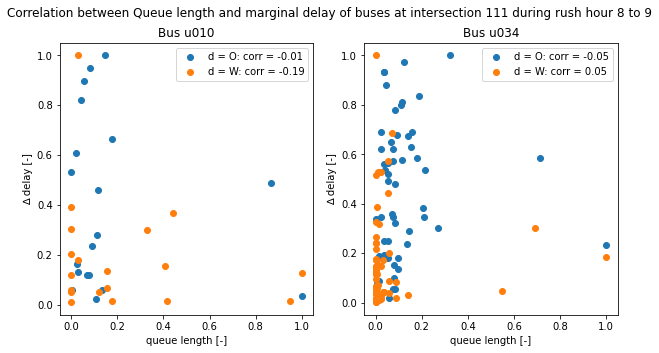

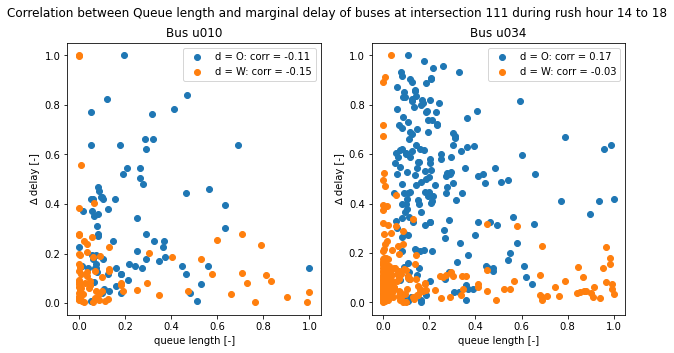

In [20]:
#time span for detailed analysis
t_morning = [8, 9]
t_evening = [14, 18]
#Normalisation to 0,1 / or -1,1
normalised = 'yes'
#intersection of interest
vri= 111
#busline of interest
# vri 89:'u001', 'u010', 'u034', 'u047'
# vri 111: 'u010', 'u034'
lines = ['u010', 'u034']
for t_int in [t_morning, t_evening]:
    t_start = t_int[0]
    t_end = t_int[1]
    
    fig = plt.figure(figsize=(len(lines)*5, 5))
    
    for i,line in enumerate(lines): 
        #plots
        ax=plt.subplot(1,len(lines), i+1)
        ax.grid(visible = None, which = 'both')
        ax.set_xlabel('queue length [-]')
        #ax.set_xlim([-0.1, 1.1])
        ax.set_ylabel('∆ delay [-]')
        #ax.set_ylim([-0.1, 1.1])
        ax.set_title('Bus {}'.format(line))
        plt.suptitle('Correlation between Queue length and marginal delay of buses at intersection {} during rush hour {} to {}'.format(vri,t_start, t_end))
    
        for stops in [0,1]:
        #setting direction according to stops couple
            if stops == 0:
                d = 'O'
            elif stops == 1:
                d = 'W'
            df_ql = queuelength[vri][d][queuelength[vri][d].index.hour>= t_start]
            df_ql = df_ql[df_ql.index.hour < t_end]
            #display(df_ql)
    
            bus = bus_agg_compl[vri][line][stops][bus_agg_compl[vri][line][stops].index.hour>= t_start]
            bus = bus[bus.index.hour < t_end]
            #display(bus)
            
            #algin the two data frames
            df_ql['delay_bus'] = df_ql.align(bus, axis = 0)[1]['marg_delay']['mean']
            #drop the nan rows
            df_ql = df_ql.dropna()
            #calculate rho
            ql = df_ql.buffervulling_m['mean']
            delay_bus = df_ql['delay_bus']
            rho = np.corrcoef(ql, delay_bus)
            #normalised plot
            if normalised == 'yes':
                ql_norm =(ql-np.min(ql))/(np.max(ql)-np.min(ql))
                delay_norm = abs(delay_bus)/np.max(abs(delay_bus))
                ax.scatter(ql_norm, delay_norm, label = 'd = {}: corr = {}'.format(d, round(rho[0,1], 2)))
            else:

                ax.scatter(ql, delay_bus, label = 'approach {}_{}'.format(vri, d))

        ax.legend(loc='upper right')
    plt.show()
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/correlation_vri{}_time_{}_{}_date_{}_{}.pdf'.format(vri, t_start, t_end, start, end))



### using initial delay

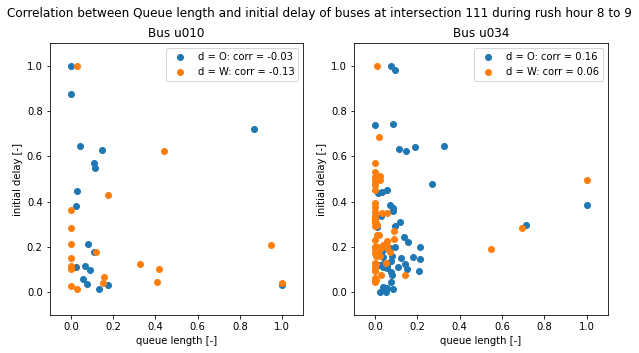

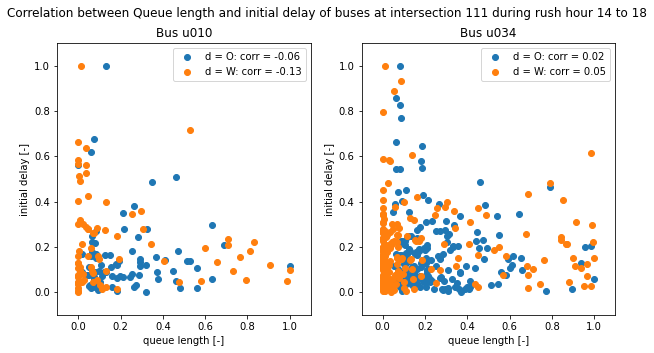

In [21]:
#time span for detailed analysis
t_morning = [8, 9]
t_evening = [14, 18]
#Normalisation to 0,1 / or -1,1
normalised = 'yes'
#intersection of interest
vri= 111
#busline of interest
# vri 89:'u001', 'u010', 'u034', 'u047'
# vri 90: 'u010'
# vri 111: 'u010', 'u034'
lines = ['u010', 'u034']
for t_int in [t_morning, t_evening]:
    t_start = t_int[0]
    t_end = t_int[1]
    
    fig = plt.figure(figsize=(len(lines)*5, 5))
    
    for i,line in enumerate(lines): 
        #plots
        ax=plt.subplot(1,len(lines), i+1)
        ax.grid(visible = None, which = 'both')
        ax.set_title('Bus {}'.format(line))
        plt.suptitle('Correlation between Queue length and initial delay of buses at intersection {} during rush hour {} to {}'.format(vri,t_start, t_end))
    
        for stops in [0,1]:
        #setting direction according to stops couple
            if stops == 0:
                d = 'O'
            elif stops == 1:
                d = 'W'
            df_ql = queuelength[vri][d][queuelength[vri][d].index.hour>= t_start]
            df_ql = df_ql[df_ql.index.hour < t_end]
    
            bus = delay_bf[vri][line][stops][delay_bf[vri][line][stops].index.hour>= t_start]
            bus = bus[bus.index.hour < t_end]
            #display(bus)
            
            #algin the two data frames
            df_ql['delay_bus'] = df_ql.align(bus, axis = 0)[1]['punctuality']['mean']
            #drop the nan rows
            df_ql = df_ql.dropna()
            #calculate rho
            ql = df_ql.buffervulling_m['mean']
            delay_bus = df_ql['delay_bus']
            rho = np.corrcoef(ql, delay_bus)
            #normalised plot
            if normalised == 'yes':
                ql_norm =(ql-np.min(ql))/(np.max(ql)-np.min(ql))
                delay_norm = abs(delay_bus)/np.max(abs(delay_bus))
                ax.scatter(ql_norm, delay_norm, label = 'd = {}: corr = {}'.format(d, round(rho[0,1], 2)))
                ax.set_xlabel('queue length [-]')
                ax.set_xlim([-0.1, 1.1])
                ax.set_ylabel('initial delay [-]')
                ax.set_ylim([-0.1, 1.1])
            else:
                ax.scatter(ql, delay_bus, label = 'approach {}_{}'.format(vri, d))
                ax.set_xlabel('queue length [m]')
                ax.set_ylabel('initial delay [s]')

        ax.legend(loc='upper right')
    plt.show()
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/correlation_INTIAL_DELAY_vri{}_time_{}_{}_date_{}_{}.pdf'.format(vri, t_start, t_end, start, end))



### Scatter plot with averaged values by the time of the day

### using marginal delay of buses

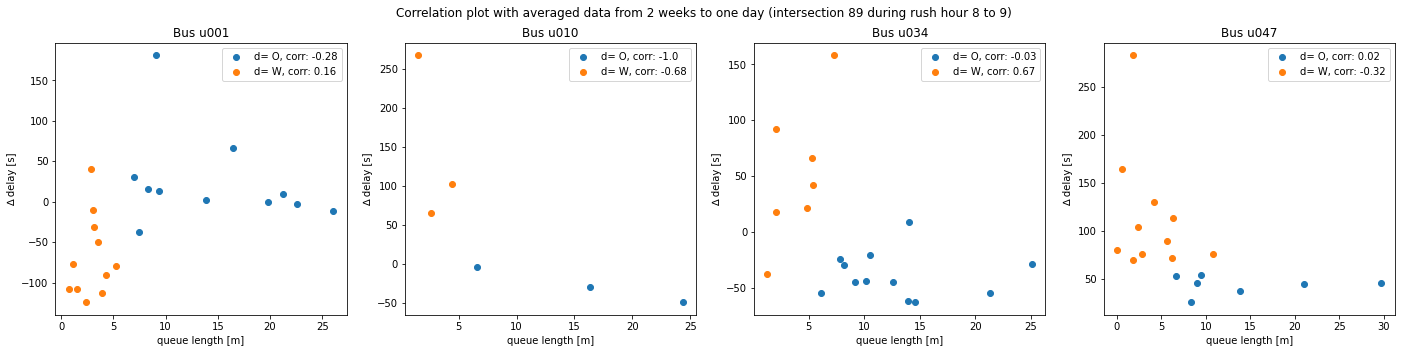

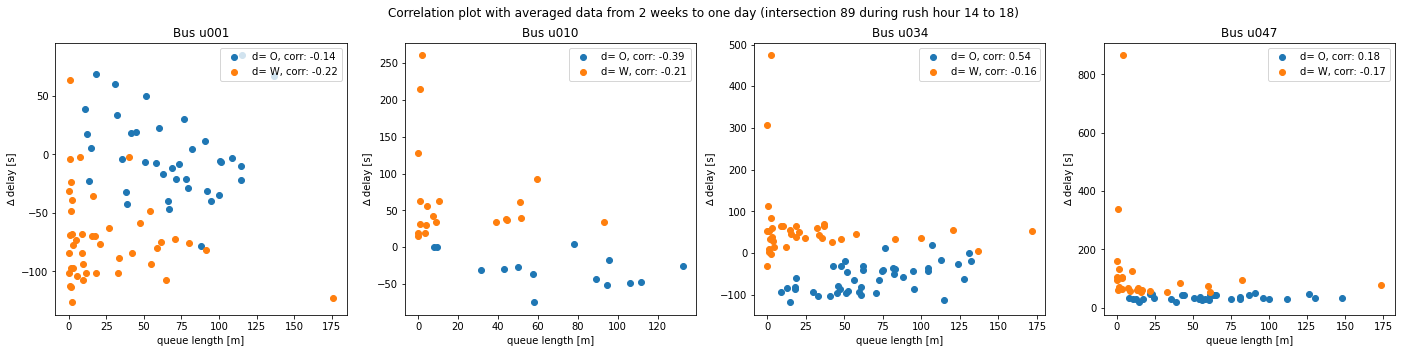

In [22]:
#Normalisation to 0,1 / or -1,1
normalised = 'no'
#intersection of interest
vri= 89
#busline of interest
# vri 89:'u001', 'u010', 'u034', 'u047'
# vri 111: 'u010', 'u034'
lines = ['u001', 'u010', 'u034', 'u047']
for t_int in [t_morning, t_evening]:
    t_start = t_int[0]
    t_end = t_int[1]
    
    fig = plt.figure(figsize=(len(lines)*6, 5))
    for i,line in enumerate(lines):
      #plots
      ax=plt.subplot(1,len(lines), i+1)
      ax.grid(visible = None, which = 'both')

      ax.set_title('Bus {}'.format(line))
      plt.suptitle('Correlation plot with averaged data from 2 weeks to one day (intersection {} during rush hour {} to {})'.format(vri,t_start, t_end))

      for stops in [0,1]:
      #setting direction according to stops couple
          if stops == 0:
              d = 'O'
          elif stops == 1:
              d = 'W'
          df_ql = queuelength[vri][d][queuelength[vri][d].index.hour>= t_start]
          df_ql = df_ql[df_ql.index.hour < t_end]

          bus = bus_agg_compl[vri][line][stops][bus_agg_compl[vri][line][stops].index.hour>= t_start]
          bus = bus[bus.index.hour < t_end]
          
          #algin the two data frames
          df_ql['delay_bus'] = df_ql.align(bus, axis = 0)[1]['marg_delay']['mean']
          #drop the nan rows
          df_ql = df_ql.dropna()
          
          #calculate rho
          ql = df_ql.buffervulling_m['mean']
          delay_bus = df_ql['delay_bus']

          #average per time of the day
          ##PT data
          delay_bus = pd.DataFrame(delay_bus)
          delay_bus.insert(1, "h min",[x.time() for x in delay_bus.index], True )
          bus_avg_day = delay_bus.groupby(delay_bus['h min']).mean()

          ##Queue length
          ql = pd.DataFrame(ql)
          ql.insert(1, "h min",[x.time() for x in ql.index], True)
          ql_avg_day = ql.groupby(ql['h min']).mean()

          # plot
          if normalised == 'yes':
            ql_norm = (ql_avg_day-np.min(ql_avg_day))/(np.max(ql_avg_day)-np.min(ql_avg_day))
            delay_norm = bus_avg_day/np.max(abs(bus_avg_day))
            rho_norm = np.corrcoef(ql_norm['mean'], delay_norm['delay_bus'])
            ax.scatter(ql_norm, delay_norm, label = 'd = {}: corr = {}'.format(d,round(rho_norm[0,1], 2)))
            ax.set_xlabel('queue length [-]')
            ax.set_ylabel('∆ delay [-]')
            ax.set_ylim(-1.1,1.1)
          else:
            rho = np.corrcoef(ql_avg_day['mean'], bus_avg_day['delay_bus'])
            ax.scatter(ql_avg_day, bus_avg_day, label = 'd= {}, corr: {}'.format(d, round(rho[0,1], 2)))
            ax.set_xlabel('queue length [m]')
            ax.set_ylabel('∆ delay [s]')

      ax.legend(loc='upper right')#bbox_to_anchor =(1,0.5),
    plt.show()
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/correlation_averaged_vri{}_time_{}_{}_date_{}_{}.pdf'.format(vri, t_start, t_end, start, end))

### using initial delay of buses

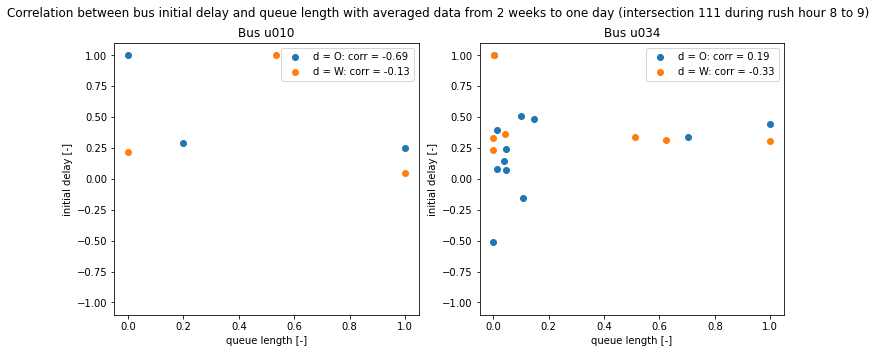

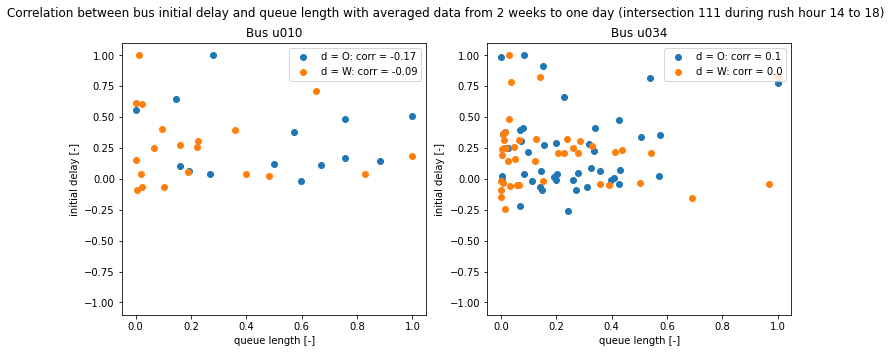

In [23]:
#Normalisation to 0,1 / or -1,1
normalised = 'yes'
#intersection of interest
vri= 111
#busline of interest
# vri 89:'u001', 'u010', 'u034', 'u047'
# vri 111: 'u010', 'u034'
lines = ['u010', 'u034']
for t_int in [t_morning, t_evening]:
    t_start = t_int[0]
    t_end = t_int[1]
    
    fig = plt.figure(figsize=(len(lines)*6, 5))
    for i,line in enumerate(lines):
      #plots
      ax=plt.subplot(1,len(lines), i+1)
      ax.grid(visible = None, which = 'both')

      ax.set_title('Bus {}'.format(line))
      plt.suptitle('Correlation between bus'' initial delay and queue length with averaged data from 2 weeks to one day (intersection {} during rush hour {} to {})'.format(vri,t_start, t_end))

      for stops in [0,1]:
      #setting direction according to stops couple
          if stops == 0:
              d = 'O'
          elif stops == 1:
              d = 'W'
          df_ql = queuelength[vri][d][queuelength[vri][d].index.hour>= t_start]
          df_ql = df_ql[df_ql.index.hour < t_end]

          bus = delay_bf[vri][line][stops][delay_bf[vri][line][stops].index.hour>= t_start]
          bus = bus[bus.index.hour < t_end]
          
          #algin the two data frames
          df_ql['delay_bus'] = df_ql.align(bus, axis = 0)[1]['punctuality']['mean']
          #drop the nan rows
          df_ql = df_ql.dropna()
          
          #calculate rho
          ql = df_ql.buffervulling_m['mean']
          delay_bus = df_ql['delay_bus']

          #average per time of the day
          ##PT data
          delay_bus = pd.DataFrame(delay_bus)
          delay_bus.insert(1, "h min",[x.time() for x in delay_bus.index], True )
          bus_avg_day = delay_bus.groupby(delay_bus['h min']).mean()

          ##Queue length
          ql = pd.DataFrame(ql)
          ql.insert(1, "h min",[x.time() for x in ql.index], True)
          ql_avg_day = ql.groupby(ql['h min']).mean()

          # plot
          if normalised == 'yes':
            ql_norm = (ql_avg_day-np.min(ql_avg_day))/(np.max(ql_avg_day)-np.min(ql_avg_day))
            delay_norm = bus_avg_day/np.max(abs(bus_avg_day))
            rho_norm = np.corrcoef(ql_norm['mean'], delay_norm['delay_bus'])
            ax.scatter(ql_norm, delay_norm, label = 'd = {}: corr = {}'.format(d,round(rho_norm[0,1], 2)))
            ax.set_xlabel('queue length [-]')
            ax.set_ylabel('initial delay [-]')
            ax.set_ylim(-1.1,1.1)
          else:
            rho = np.corrcoef(ql_avg_day['mean'], bus_avg_day['delay_bus'])
            ax.scatter(ql_avg_day, bus_avg_day, label = 'd= {}, corr: {}'.format(d, round(rho[0,1], 2)))
            ax.set_xlabel('queue length [m]')
            ax.set_ylabel('initial delay [s]')

      ax.legend(loc='upper right')#bbox_to_anchor =(1,0.5),
    plt.show()
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/correlation_INITIAL_DELAY_averaged_vri{}_time_{}_{}_date_{}_{}.pdf'.format(vri, t_start, t_end, start, end))